# <center>Lab5
1. **数据预处理**。需要注意，提供数据包含大量冗余随机特征、outlier数据以及Null数据，你需要综合运用所学的知识进行数据降维、降噪、补缺、特征提取、编码以及必要的其他数据预处理工作。
2. **数据划分**。你需要将所提供的`train`数据集按照所学的方法拆分成训练集以及测试集。
3. **模型训练**。你需要分别使用本课程所学习的线性回归模型、决策树模型、神经网络模型、支持向量机以及XGBoost等分类模型来完成标签预测任务。
4. **模型验证**。你需要将`test_feature.csv`的数据输入到一个你认为性能最佳的模型中，然后仿照`train_label.csv`的文件格式生成对应标签数据文件，命名为`test_label.csv`，并将它包含在你所提交的压缩包中。
5. **实验分析**。你需要仔细撰写实验报告以及相关分析。

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("paper")  
sns.set(rc={'figure.figsize': (10, 8)})  # 设置画板大小
sns.set_style('whitegrid')

## 1. 数据预处理
按照以下流程进行数据预处理：

1.1 数据读取

1.2 数据去噪

（1）挑选出outliers

（2）设置为nan，等待第5步处理

1.3 数据降维
    
（1）主成分分析

（2）特征相关性

1.4 数据标准化

1.5 数据缺失值处理

（1）均值填充

（2）KNN填充

有2点需要说明：

（1）将 1.5 数据缺失值处理 放在 1.4 数据标准化 后面，是因为KNN填充要求各个属性在相同尺度的空间中，否则 值更大的属性对距离的贡献会比值小的属性大

（2）主成分分析时，特征取值不能为nan，因此将nan都先进行均值填充

### 1.1 数据读取

In [2]:
X_df = pd.read_csv('Dataset/train_feature.csv')
y_df = pd.read_csv('Dataset/train_label.csv')
X_pred_df = pd.read_csv('Dataset/test_feature.csv')
c = y_df['label'].unique().__len__()
# 计算y_df中每个label的数量
y_df['label'].value_counts()

0    2523
1    2521
2    2500
3    2456
Name: label, dtype: int64

### 1.2 数据降噪

In [3]:
X_df.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119
count,9960.000000,9946.000000,9955.000000,9952.000000,9954.000000,9.955000e+03,9956.000000,9956.000000,9935.000000,9954.000000,...,9951.000000,9942.000000,9949.000000,9953.000000,9971.000000,9954.000000,9966.000000,9945.000000,9961.000000,9955.000000
mean,1381.896486,58.715384,11.157463,215.609224,104.244826,5.159948e+03,1418.185014,193.551326,49.467136,228.066855,...,116.686062,27.416274,1535.670218,15.054217,148.445119,59.534157,1492.845976,26.923894,53.122879,1608.872828
std,20342.092034,3067.018960,213.548216,3254.119426,1809.139214,8.325174e+04,21803.434424,3078.353897,1062.106891,4636.090534,...,1933.557182,562.969699,22002.428225,226.915755,3492.678496,1054.340669,22568.166582,570.147079,1009.911312,23191.540756
min,26.000000,-72400.900016,0.000004,3.000000,0.000000,0.000000e+00,27.000000,3.000000,1.000000,0.042353,...,0.000000,0.000128,27.000000,0.000122,0.051135,0.000000,24.000000,0.000010,0.000000,26.000000
25%,45.000000,-5.442525,0.248601,7.000000,3.000000,1.620000e+02,45.000000,7.000000,1.000000,1.390866,...,3.000000,0.289902,45.000000,0.255261,1.384008,1.000000,45.000000,0.294560,1.000000,45.000000
50%,50.000000,-0.060218,0.504924,8.000000,4.000000,1.940000e+02,50.000000,8.000000,2.000000,2.730417,...,4.000000,0.708386,50.000000,0.511428,2.789308,2.000000,50.000000,0.702308,2.000000,50.000000
75%,55.000000,5.482893,0.751965,8.000000,5.000000,2.220000e+02,55.000000,8.000000,4.000000,5.413222,...,5.000000,1.440402,55.000000,0.760929,5.354379,3.000000,54.000000,1.399526,3.000000,55.000000
max,526876.000000,105832.015208,8448.902842,79794.000000,57936.000000,2.072000e+06,505945.000000,81060.000000,47816.000000,210388.669161,...,66493.000000,29581.611161,514420.000000,6983.682765,195804.282475,49235.000000,632196.000000,23978.517876,40870.000000,564200.000000


In [4]:
### 将各个属性的outliers值设置为nan
def set_outliers_nan(df, col):
    # 计算iqr：数据四分之三分位值与四分之一分位值的差
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
    # 根据iqr计算异常值判断阈值
    u_bound = df[col].quantile(0.75) + 1.5*iqr # 上界
    l_bound = df[col].quantile(0.25) - 1.5*iqr # 下界
    # 将离群点设为nan
    df.loc[df[(df[col] < l_bound) | (df[col] > u_bound)].index,[col]] = np.nan
    return df

for col in X_df.columns:
    X_df = set_outliers_nan(X_df, col)
    
for col in X_pred_df.columns:
    X_pred_df = set_outliers_nan(X_pred_df, col)

X_df.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119
count,9882.000000,9837.000000,9913.000000,8471.000000,9705.000000,9872.000000,9880.000000,8505.000000,9596.000000,9158.000000,...,9706.000000,9447.000000,9862.000000,9896.000000,9166.000000,9869.000000,9813.000000,9454.000000,9875.000000,9861.000000
mean,50.033799,-0.020860,0.502450,7.508323,3.853787,190.851712,50.006073,7.495121,2.606607,3.241416,...,3.878014,0.866993,50.034070,0.504577,3.246630,1.990779,49.749414,0.851144,1.982785,49.943211
std,6.824611,7.831458,0.288902,1.012039,1.841726,38.984259,6.749713,1.001530,1.775989,2.532188,...,1.839337,0.736846,6.806394,0.290259,2.514303,1.364326,6.612250,0.717194,1.381651,6.838074
min,30.000000,-21.788610,0.000004,6.000000,0.000000,72.000000,30.000000,6.000000,1.000000,0.042353,...,0.000000,0.000128,30.000000,0.000122,0.051135,0.000000,32.000000,0.000010,0.000000,30.000000
25%,45.000000,-5.396518,0.247179,7.000000,3.000000,163.000000,45.000000,7.000000,1.000000,1.310776,...,3.000000,0.270198,45.000000,0.253482,1.294820,1.000000,45.000000,0.276772,1.000000,45.000000
50%,50.000000,-0.062230,0.503622,7.000000,4.000000,194.000000,50.000000,7.000000,2.000000,2.456389,...,4.000000,0.654283,50.000000,0.509181,2.508074,2.000000,50.000000,0.654174,2.000000,50.000000
75%,55.000000,5.392495,0.749282,8.000000,5.000000,222.000000,55.000000,8.000000,4.000000,4.502215,...,5.000000,1.289133,55.000000,0.757965,4.527142,3.000000,54.000000,1.249729,3.000000,54.000000
max,70.000000,21.637877,0.999984,9.000000,8.000000,303.000000,70.000000,9.000000,8.000000,11.424614,...,8.000000,3.164811,70.000000,0.999949,11.297454,6.000000,67.000000,3.055076,6.000000,70.000000


### 1.3 数据降维

（1）主成分分析

In [5]:
# 首先，对所有nan进行均值填充
X_df_n = X_df.copy()
for col in list(X_df.columns[X_df.isnull().sum() > 0]):
    mean_val = X_df[col].mean()
    X_df_n[col].fillna(mean_val, inplace=True)


In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 20)
X_n = X_df_n.values
pca_X = pca.fit_transform(X_n)
pca_X_df = pd.DataFrame(pca_X)

pca.explained_variance_ratio_.sum()

0.8876020977333661

（2） 特征相关性

In [7]:
# 特征相关性热图
def draw_corr_heatmap(df, method='pearson'):
	corr_heatmap = df.corr(method=method)
	sns.heatmap(corr_heatmap, cmap='coolwarm')
	return corr_heatmap

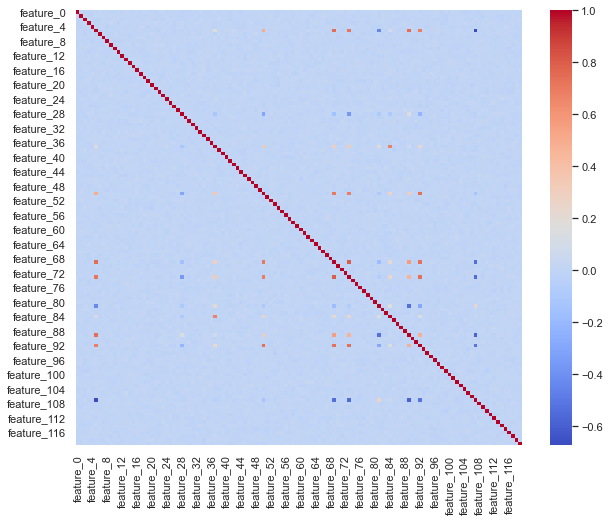

In [8]:
corr_heatmap = draw_corr_heatmap(X_df, method='pearson')

In [9]:
# 将corr_heatmap转换为np.matrix
corr_heatmap = corr_heatmap.values
# 将对角线元素置为0, 将所有值变为绝对值
for i in range(corr_heatmap.shape[0]):
    corr_heatmap[i, i] = 0
abs_corr_heatmap = np.abs(corr_heatmap)

In [10]:
# 简单定义一个gather_corr量，为每个属性与其他属性的相关性的绝对值之和
# 取gather_corr前11个属性（heatmap中有11个关联性高的特征）作为特征
gather_corr = np.sum(abs_corr_heatmap, axis=0)
selected_feat_idx = np.argsort(gather_corr)[-11:]
selected_feat_idx.sort()
selected_X_df = X_df.iloc[:, selected_feat_idx]

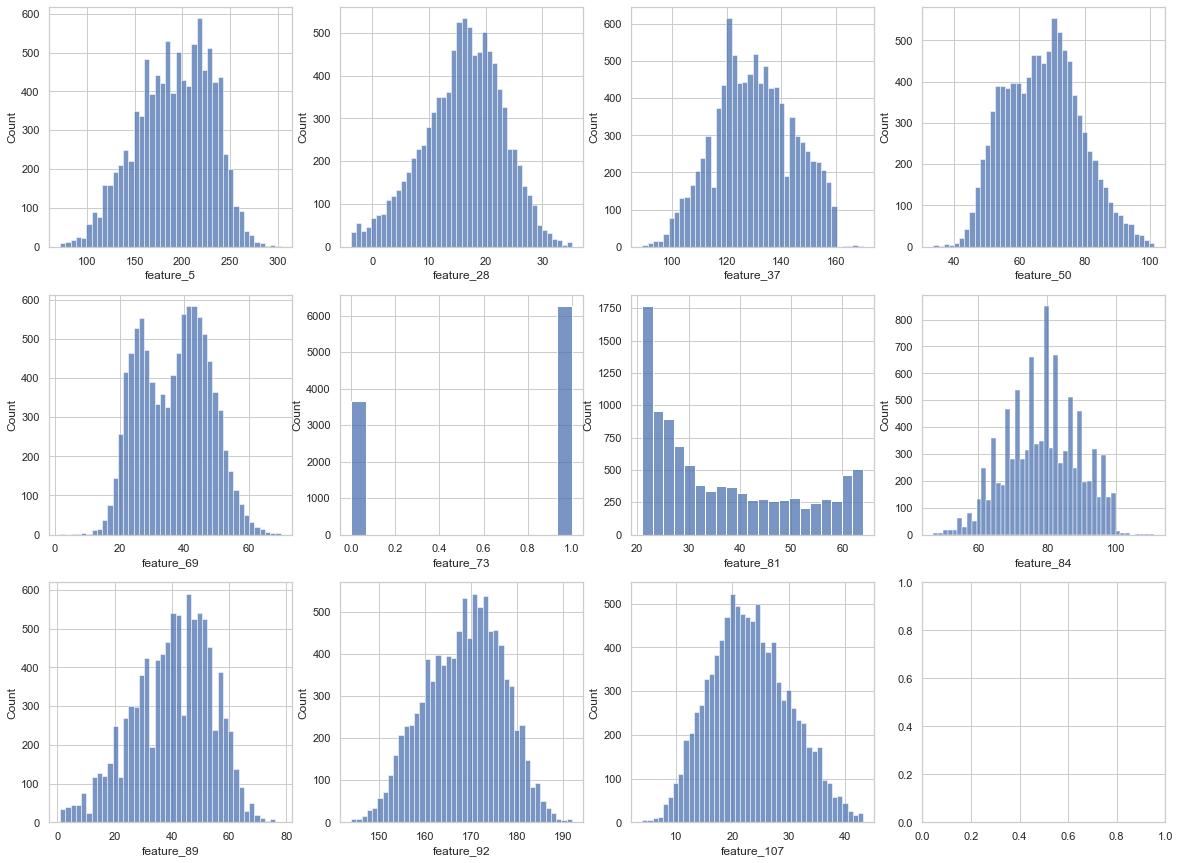

In [11]:
# 画出selected_X_df的直方图, 每行4个子图
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
for i, ax in enumerate(axes.flatten()):
    if i <= selected_X_df.shape[1] - 1:
        sns.histplot(selected_X_df.iloc[:, i], ax=ax)
    else:
        break

对比一下其余的属性分布, 此处以前30个特征为例

可以明显看出其余分布为人为设定的噪声，如正态分布（feature 0,1）、beta分布（feature 9,19）、均匀分布（feature 2,16）等

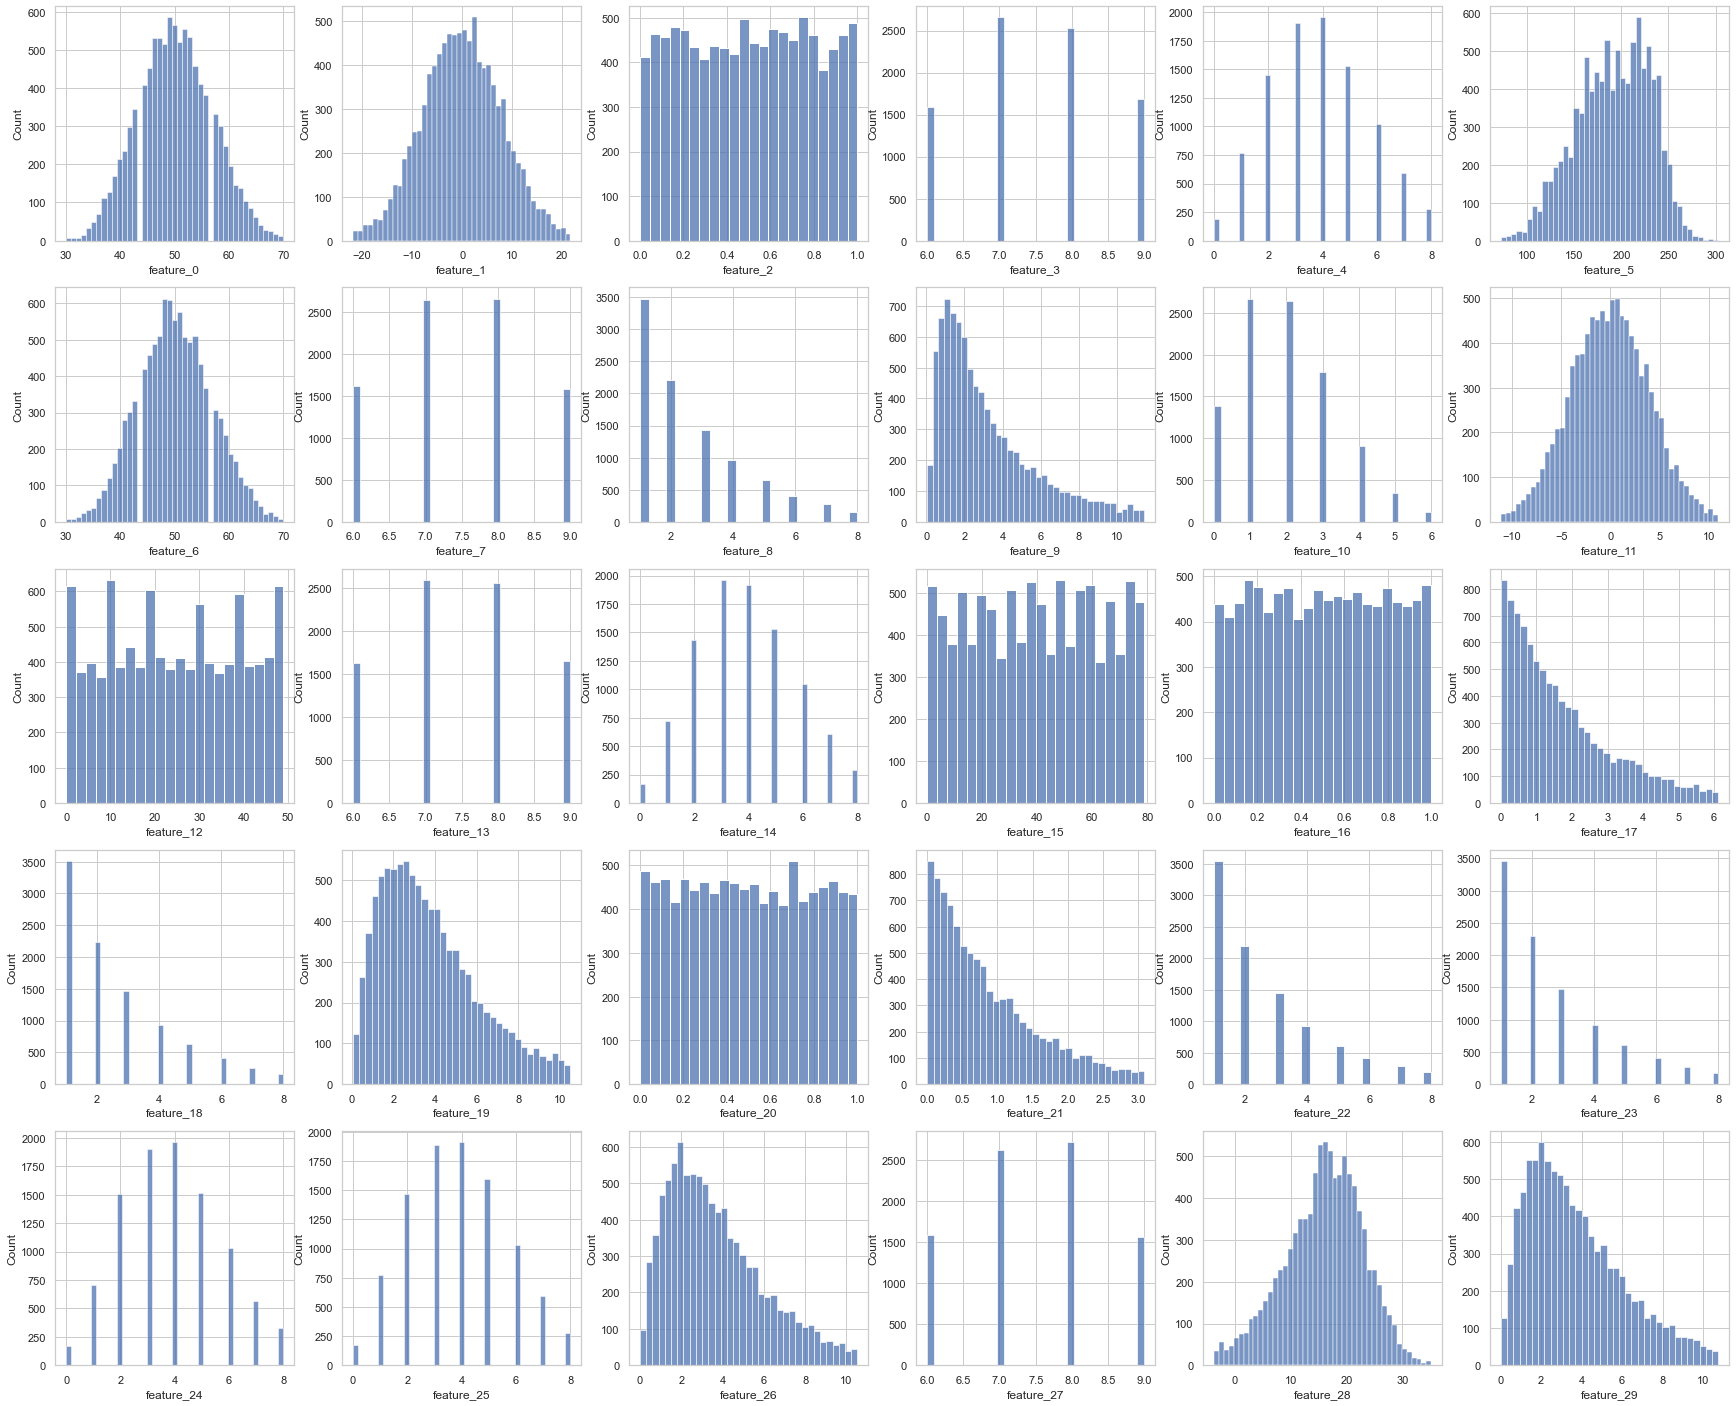

In [12]:
fig, axes = plt.subplots(5, 6, figsize=(30, 25))
for i, ax in enumerate(axes.flatten()):
    sns.histplot(X_df.iloc[:, i], ax=ax)

### 1.4 数据标准化

In [13]:
from sklearn.preprocessing import StandardScaler

scaler1 = StandardScaler()
scaler1.fit(pca_X_df)
scale_pca_X = scaler1.transform(pca_X_df)
scale_pca_X_df = pd.DataFrame(scale_pca_X)

scaler2 = StandardScaler()
scaler2.fit(selected_X_df)
scale_selected_X = scaler2.transform(selected_X_df)
scale_selected_X_df = pd.DataFrame(scale_selected_X)

In [14]:
scale_pca_X_df.shape, scale_selected_X_df.shape

((10000, 20), (10000, 11))

### 1.5 数据缺失值处理

In [15]:
scale_pca_X_df.isnull().sum().sum(), scale_selected_X_df.isnull().sum().sum()

(0, 1609)

scale_pca_X_df 无 nan

scale_selected_X_df 有 nan 需要填充

（1）均值填充

In [16]:
mean_scale_selected_X_df = scale_selected_X_df.copy()
for col in list(scale_selected_X_df.columns[scale_selected_X_df.isnull().sum() > 0]):
    mean_val = scale_selected_X_df[col].mean()
    mean_scale_selected_X_df[col].fillna(mean_val, inplace=True)

（2）KNN填充

In [17]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
scale_selected_X = scale_selected_X_df.values
knn_scale_selected_X = imputer.fit_transform(scale_selected_X)
# X_pred = imputer.transform(X_pred)                                              # 对预测目标进行填补
knn_scale_selected_X_df = pd.DataFrame(knn_scale_selected_X)

## End 数据预处理
处理完之后得到四组数据，如下

In [18]:
X1 = scale_pca_X_df.values
y1 = y_df.values
X1.shape, y1.shape

((10000, 20), (10000, 1))

In [19]:
X2 = mean_scale_selected_X_df.values
y2 = y_df.values
X2.shape, y2.shape

((10000, 11), (10000, 1))

In [20]:
X3 = knn_scale_selected_X_df.values
y3 = y_df.values
X3.shape, y3.shape

((10000, 11), (10000, 1))

## 2. 数据划分

In [21]:
def data_split(X, y, test_size=0.2, random_state=42):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [22]:
X1_train, X1_test, y1_train, y1_test = data_split(X1, y1)
X2_train, X2_test, y2_train, y2_test = data_split(X2, y2)
X3_train, X3_test, y3_train, y3_test = data_split(X3, y3)

## 3. 模型训练

- 线性回归模型
- 决策树模型
- 神经网络模型 
- 支持向量机
- XGBoost

Logistic

In [34]:
# Logistic Regression 二分类
class LogisticRegression:
    
    def __init__(self, penalty="l2", gamma=0.01, lr=0.1, n_in=11, n_out=1, max_iter=100000, lr_decay_times=10):
        # constraint penalty type
        err_msg = "penalty must be 'l1' or 'l2', but got: {}".format(penalty)
        assert penalty in ["l2", "l1"], err_msg
        # learnable parameters
        self.w = np.ones((n_in, n_out)) # (n_in, n_out)
        self.b = np.zeros((n_out, 1)) # (n_out, 1)
        # coefficients
        self.gamma = gamma
        # learning rate
        self.lr = lr
        # penalty
        self.penalty = penalty
        # max iteration
        self.max_iter = max_iter
        # numerical stability
        self.EPS = 1e-5
        self.clip = 5
        # lr decay times
        self.flag = lr_decay_times

    def sigmoid(self, x):
        """
        The logistic sigmoid function
        """
        # clip to avoid overflow
        x = np.clip(x, -self.clip, self.clip)
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        """
        The derivative of the logistic sigmoid function
        """
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def forward(self, x):
        """
        Forward pass of the model
        """
        y_hat = self.sigmoid(x @ self.w + self.b) # (bsz, n_out)
        return y_hat

    def loss(self, y_hat, y):
        # +1e-5 to avoid log(0)
        ce_loss = -np.mean(y*np.log(y_hat+self.EPS) + (1-y)*np.log(1-y_hat+self.EPS), axis=0)
        pel = 1./2 * self.gamma * np.sum(self.w**2)  if self.penalty == "l2" else self.gamma * np.sum(np.abs(self.w))
        return (ce_loss + pel).item()

    def backward(self, x, y):
        y_hat = self.forward(x)     # (bsz, n_out)

        # chain rule
        d_L_d_y_hat = -y/(y_hat+self.EPS) + (np.ones_like(y)-y)/(np.ones_like(y)-y_hat+self.EPS) # (bsz, n_out)
        d_y_hat_d_o = self.sigmoid_derivative(y_hat)                         # (bsz, n_out)
        d_o_d_w = x # (bsz, n_in)
        d_o_d_b = np.ones((x.shape[0], 1)) # (bsz, 1)
        d_L_d_w = np.mean(d_L_d_y_hat * d_y_hat_d_o * d_o_d_w, axis=0) # (n_in, n_out)
        d_L_d_w = d_L_d_w.reshape(self.w.shape)
        d_L_d_b = np.mean(d_L_d_y_hat * d_y_hat_d_o * d_o_d_b, axis=0) # (n_out, 1)
        # gradient descent
        self.w = self.w - self.lr * d_L_d_w # (n_in, n_out)
        self.b = self.b - self.lr * d_L_d_b # (n_out, 1)
        # regularization
        if self.penalty == "l2":
            self.w = self.w - self.gamma * self.w
        else:
            self.w = self.w - self.gamma * np.sign(self.w)

    def predict(self, x, y):
        """
        correct are those whose prediction is correct, i.e. y_hat > 0.5 and y = 1
        """
        y_hat = self.forward(x)
        y_pred = np.where(y_hat > 0.5, 1, 0)
        acc1 = np.mean(y_pred == y)
        return acc1, y_hat

    def fit(self, x, y, x_val, y_val):
        """
        Fit the regression coefficients via gradient descent or other methods 
        """
        # save for loss curve
        losses = []
        # save for max acc
        max_acc = 0
        # save last 10 losses for early stopping
        last_10_loss = []
        # get data ready
        x = np.array(x)
        y = np.array(y)
        y = y.reshape(y.shape[0], 1)
        x_val = np.array(x_val)
        y_val = np.array(y_val)
        y_val = y_val.reshape(y_val.shape[0], 1)
        # lr decay times initialize as 0
        flag = 0
        # training loop
        for i in range(self.max_iter):
            self.backward(x, y)
            y_hat = self.forward(x)
            loss = self.loss(y_hat, y)
            losses.append(loss)
            # print(x_val.shape, y_val.shape)
            acc, _ = self.predict(x_val, y_val)
            if acc > max_acc:
                max_acc = acc
                # print("iter:", i, "loss:", loss, "current_max_acc:", acc)
            # check for lr decay every 10 iterations
            if i % 10 == 0:
                if len(last_10_loss) < 10:
                    last_10_loss.append(loss)
                else:
                    if loss >= np.mean(last_10_loss):
                        if flag < self.flag:
                            # print("iter:", i, "loss:", loss, "acc:", acc)
                            # print("loss increase, lr decay")
                            self.lr = self.lr * 0.5
                            flag += 1
                        else:
                            # print("iter:", i, "loss:", loss, "acc:", acc)
                            # print("early stop")
                            break
                    else:
                        last_10_loss.pop(0)
                        last_10_loss.append(loss)
        # print("max acc:", max_acc)

In [35]:
# 将二分类通过OvR（One vs Rest）的方式转化为多分类问题
def OvR(x, y, x_val, y_val, binary_classifier):
    
    n_class = len(np.unique(y))
    n_feature = x.shape[1]
        
    # train the model
    binary_labels = []
    for i in range(n_class):
        model = None
        model = binary_classifier

        # 为每个二分类问题训练一个模型
        y_ = np.array([1 if j == i else 0 for j in y]).reshape(-1, 1)
        y_val_ = np.array([1 if j == i else 0 for j in y_val]).reshape(-1, 1)
        model.fit(x, y_, x_val, y_val_)
        
        a, binary_label = model.predict(x_val, y_val_.reshape(-1, 1))
        binary_labels.append(binary_label)
        
    binary_labels = np.array(binary_labels)
    multi_label = np.argmax(binary_labels, axis=0)
    return multi_label

In [36]:
def train_logistic(X_train, y_train, X_test, y_test, **kargs):
    penalty, gamma, lr = kargs.get("penalty"), kargs.get("gamma"), kargs.get("lr")
    binary_classifier = LogisticRegression(penalty=penalty, gamma=gamma, lr=lr, n_in=X_train.shape[1], n_out=1, max_iter=1000, lr_decay_times=3)
    y1_pred = OvR(X_train, y_train, X_test, y_test, binary_classifier)
    acc = np.mean(y1_pred == y1_test)
    return acc

In [60]:
best_acc = 0
best_info = None
for penalty in ["l1", "l2"]:
    for gamma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]:
        for lr in [0.1, 0.2, 0.5, 1]:
            acc = train_logistic(X1_train, y1_train, X1_test, y1_test, penalty=penalty, gamma=gamma, lr=lr)
            info = (penalty, gamma, lr)
            if acc > best_acc:
                best_acc = acc
                best_info = info
print("best_acc:", best_acc, "penalty:", best_info[0], "gamma:", best_info[1], "lr:", best_info[2])

best_acc: 0.264 penalty: l1 gamma: 0.1 lr: 1


In [39]:
best_acc = 0
best_info = None
for penalty in ["l1", "l2"]:
    for gamma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]:
        for lr in [0.1, 0.2, 0.5, 1]:
            acc = train_logistic(X2_train, y2_train, X2_test, y2_test, penalty=penalty, gamma=gamma, lr=lr)
            info = (penalty, gamma, lr)
            if acc > best_acc:
                best_acc = acc
                best_info = info
print("best_acc:", best_acc, "penalty:", best_info[0], "gamma:", best_info[1], "lr:", best_info[2])

best_acc: 0.2765 penalty: l1 gamma: 0.5 lr: 1


penalty: l1 gamma: 0.1 lr: 0.5 acc: 0.2725

In [57]:
best_acc = 0
best_info = None
for penalty in ["l1", "l2"]:
    for gamma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]:
        for lr in [0.1, 0.2, 0.5, 1]:
            acc = train_logistic(X3_train, y3_train, X3_test, y3_test, penalty=penalty, gamma=gamma, lr=lr)
            info = (penalty, gamma, lr)
            if acc > best_acc:
                best_acc = acc
                best_info = info
print("best_acc:", best_acc, "penalty:", best_info[0], "gamma:", best_info[1], "lr:", best_info[2])

best_acc: 0.274 penalty: l1 gamma: 1 lr: 0.1


penalty: l1 gamma: 1 lr: 0.1 acc: 0.274

Desicion Tree

分类任务，使用分类树

In [25]:
from sklearn.tree import DecisionTreeClassifier

def train_DecisionTree(X_train, y_train, X_test, y_test, criterion, random_state, max_depth=None, min_samples_leaf=1):
    clf = DecisionTreeClassifier(criterion=criterion, random_state=random_state, \
        max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    clf = clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return score

In [28]:
train_DecisionTree(X1_train, y1_train, X1_test, y1_test, criterion="gini", random_state=0, max_depth=5, min_samples_leaf=1)

0.253

In [31]:
best_acc = 0
best_info = None
for c in ["gini", "entropy"]:
    for d in [3, 5, 10, 15, 20]:
        for l in [1, 2, 5, 10, 20]:
            acc = train_DecisionTree(X1_train, y1_train, X1_test, y1_test, criterion=c, random_state=42, max_depth=d, min_samples_leaf=l)
            info = (c, d, l)
            if acc > best_acc:
                best_acc = acc
                best_info = info
print("best_acc:", best_acc, "criterion:", best_info[0], "max_depth:", best_info[1], "min_samples_leaf:", best_info[2])

best_acc: 0.2685 criterion: gini max_depth: 15 min_samples_leaf: 5


In [32]:
best_acc = 0
best_info = None
for c in ["gini", "entropy"]:
    for d in [3, 5, 10, 15, 20]:
        for l in [1, 2, 5, 10, 20]:
            acc = train_DecisionTree(X2_train, y2_train, X2_test, y2_test, criterion=c, random_state=42, max_depth=d, min_samples_leaf=l)
            info = (c, d, l)
            if acc > best_acc:
                best_acc = acc
                best_info = info
print("best_acc:", best_acc, "criterion:", best_info[0], "max_depth:", best_info[1], "min_samples_leaf:", best_info[2])

best_acc: 0.272 criterion: gini max_depth: 20 min_samples_leaf: 20


In [38]:
best_acc = 0
best_info = None
for c in ["gini", "entropy"]:
    for d in [3, 5, 10, 15, 20]:
        for l in [1, 2, 5, 10, 20]:
            acc = train_DecisionTree(X3_train, y3_train, X3_test, y3_test, criterion=c, random_state=42, max_depth=d, min_samples_leaf=l)
            info = (c, d, l)
            if acc > best_acc:
                best_acc = acc
                best_info = info
print("best_acc:", best_acc, "criterion:", best_info[0], "max_depth:", best_info[1], "min_samples_leaf:", best_info[2])

best_acc: 0.2615 criterion: entropy max_depth: 10 min_samples_leaf: 1


神经网络模型

In [97]:
from sklearn.neural_network import MLPClassifier

def train_MLP(X_train, y_train, X_test, y_test, h, a, s, lr, random_state=42):
    clf = MLPClassifier(hidden_layer_sizes=h, activation=a, solver=s, learning_rate_init=lr, max_iter=1000, random_state=random_state)
    clf.fit(X_train, y_train.ravel())
    score = clf.score(X_test, y_test)
    return score

In [54]:
best_acc = 0
best_info = None
for h in [(4,), (8,)]:
    for a in ["relu", "tanh"]:
        for s in ["sgd", "adam"]:
            for lr in [0.01, 0.05, 0.1, 0.5, 1]:
                acc = train_MLP(X1_train, y1_train, X1_test, y1_test, h, a, s, lr)
                info = (h, a, s, lr)
                if acc > best_acc:
                    best_acc = acc
                    best_info = info
print("best_acc:", best_acc, "hidden_layer_sizes:", best_info[0], "activation:", best_info[1], "solver:", best_info[2], "learning_rate_init:", best_info[3])

best_acc: 0.2705 hidden_layer_sizes: (8,) activation: tanh solver: adam learning_rate_init: 0.01


In [55]:
best_acc = 0
best_info = None
for h in [(4,), (8,)]:
    for a in ["relu", "tanh"]:
        for s in ["sgd", "adam"]:
            for lr in [0.01, 0.05, 0.1, 0.5, 1]:
                acc = train_MLP(X2_train, y2_train, X2_test, y2_test, h, a, s, lr)
                info = (h, a, s, lr)
                if acc > best_acc:
                    best_acc = acc
                    best_info = info
print("best_acc:", best_acc, "hidden_layer_sizes:", best_info[0], "activation:", best_info[1], "solver:", best_info[2], "learning_rate_init:", best_info[3])

best_acc: 0.28 hidden_layer_sizes: (8,) activation: tanh solver: adam learning_rate_init: 0.1


In [56]:
best_acc = 0
best_info = None
for h in [(4,), (8,)]:
    for a in ["relu", "tanh"]:
        for s in ["sgd", "adam"]:
            for lr in [0.01, 0.05, 0.1, 0.5, 1]:
                acc = train_MLP(X3_train, y3_train, X3_test, y3_test, h, a, s, lr)
                info = (h, a, s, lr)
                if acc > best_acc:
                    best_acc = acc
                    best_info = info
print("best_acc:", best_acc, "hidden_layer_sizes:", best_info[0], "activation:", best_info[1], "solver:", best_info[2], "learning_rate_init:", best_info[3])

best_acc: 0.273 hidden_layer_sizes: (8,) activation: relu solver: sgd learning_rate_init: 0.5


支持向量机

In [105]:
# SVM Model
class SVM:
    def __init__(self, lr=0.1):
        self.w = None
        self.b = None
        self.max_w = None
        self.max_b = None
        self.lr = lr

    def fit(self, X, y, max_iter=500):
        """
        Fit the coefficients via your methods
        """
        # max_iter是最大迭代次数
        self.num, self.dim = X.shape
        self.w = np.zeros(self.dim)
        self.b = 0
        lr = self.lr
        
        max_acc = 0
        tolerance = 0
        iteration = 0
        while iteration < max_iter:
            # 每个epoch循环更新一遍所有的alpha
            for i in range(len(y)):
                # 根据Hinge loss(线性SVM的loss)来进行梯度下降：
                # 如果 1 - y_i * (w * x_i + b) < 0，那么不需要梯度更新
                # 否则，梯度需要更新
                if (y[i] * (X[i] @ self.w + self.b)) < 1:
                    self.w -= lr * (-y[i] * X[i])
                    self.b -= lr * -y[i]

            iteration += 1
            
            # 记录最优的w和b
            acc, y_hat = self.predict(X, y)
            if acc > max_acc:
                max_acc = acc
                self.max_w = self.w
                self.max_b = self.b
            else:
                tolerance += 1
                if tolerance > 10:
                    lr *= 0.1
                    if lr < 1e-5:
                        break
                    else:
                        tolerance = 0
            # print('iter: {}, acc: {}'.format(iteration, acc))
        # print('max_acc: {}'.format(max_acc))
    
    def predict(self, X, y):
        # 预测
        """
        Use the trained model to generate prediction probabilities on a new
        collection of data points.
        """
        y_hat = X @ self.w + self.b
        y = y.reshape(-1, 1)
        y_hat = y_hat.reshape(-1, 1)
        acc = np.sum(y_hat * y > 0) / self.num
        return acc, y_hat

In [106]:
# 将二分类通过OvR（One vs Rest）的方式转化为多分类问题
def OvR(x, y, x_val, y_val, binary_classifier):
    
    n_class = len(np.unique(y))
    n_feature = x.shape[1]
        
    # train the model
    binary_labels = []
    for i in range(n_class):
        model = None
        model = binary_classifier

        # 为每个二分类问题训练一个模型
        y_ = np.array([1 if j == i else -1 for j in y]).reshape(-1, 1)
        y_val_ = np.array([1 if j == i else -1 for j in y_val]).reshape(-1, 1)
        model.fit(x, y_)
        
        a, binary_label = model.predict(x_val, y_val_.reshape(-1, 1))
        binary_labels.append(binary_label)
        
    binary_labels = np.array(binary_labels)
    multi_label = np.argmax(binary_labels, axis=0)
    return multi_label

In [107]:
def train_SVM(X_train, y_train, X_test, y_test, lr=0.1):
    binary_classifier = SVM()
    y_pred = OvR(X_train, y_train, X_test, y_test, binary_classifier)
    acc = np.mean(y_pred == y_test)
    return acc

In [108]:
best_acc = 0
best_info = None
for lr in [0.001, 0.005, 0.01, 0.05, 0.1]:
    acc = train_SVM(X1_train, y1_train, X1_test, y1_test, lr)
    if acc > best_acc:
        best_acc = acc
        best_info = lr
print("best_acc:", best_acc, "learning_rate:", best_info)

best_acc: 0.2415 learning_rate: 0.001


In [84]:
best_acc = 0
best_info = None
for lr in [0.001, 0.005, 0.01, 0.05, 0.1]:
    acc = train_SVM(X2_train, y2_train, X2_test, y2_test, lr)
    if acc > best_acc:
        best_acc = acc
        best_info = lr
print("best_acc:", best_acc, "learning_rate:", best_info)

best_acc: 0.267 learning_rate: 0.001


In [85]:
best_acc = 0
best_info = None
for lr in [0.001, 0.005, 0.01, 0.05, 0.1]:
    acc = train_SVM(X3_train, y3_train, X3_test, y3_test, lr)
    if acc > best_acc:
        best_acc = acc
        best_info = lr
print("best_acc:", best_acc, "learning_rate:", best_info)

best_acc: 0.232 learning_rate: 0.001


XGBoost

In [92]:
import xgboost as xgb

def train_XGB(X_train, y_train, X_test, y_test, lr=0.1, max_depth=5, colsample_bytree=0.8, subsample=0.8):
    clf = xgb.XGBClassifier(learning_rate=lr, max_depth=max_depth, colsample_bytree=colsample_bytree, subsample=subsample)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = np.mean(y_pred == y_test)
    return acc

In [93]:
for lr in [0.01, 0.05, 0.1, 0.5, 1]:
    for max_depth in [3, 5, 7, 9]:
        for colsample_bytree in [0.6, 0.8, 1]:
            for subsample in [0.6, 0.8, 1]:
                acc = train_XGB(X1_train, y1_train, X1_test, y1_test, lr, max_depth, colsample_bytree, subsample)
                if acc > best_acc:
                    best_acc = acc
                    best_info = (lr, max_depth, colsample_bytree, subsample)
print("best_acc:", best_acc, "learning_rate:", best_info[0], "max_depth:", best_info[1], "colsample_bytree:", best_info[2], "subsample:", best_info[3])

best_acc: 0.2503775 learning_rate: 1 max_depth: 9 colsample_bytree: 0.8 subsample: 1


In [94]:
for lr in [0.01, 0.05, 0.1, 0.5, 1]:
    for max_depth in [3, 5, 7, 9]:
        for colsample_bytree in [0.6, 0.8, 1]:
            for subsample in [0.6, 0.8, 1]:
                acc = train_XGB(X2_train, y2_train, X2_test, y2_test, lr, max_depth, colsample_bytree, subsample)
                if acc > best_acc:
                    best_acc = acc
                    best_info = (lr, max_depth, colsample_bytree, subsample)
print("best_acc:", best_acc, "learning_rate:", best_info[0], "max_depth:", best_info[1], "colsample_bytree:", best_info[2], "subsample:", best_info[3])

best_acc: 0.250479 learning_rate: 1 max_depth: 9 colsample_bytree: 0.8 subsample: 0.6


In [95]:
for lr in [0.01, 0.05, 0.1, 0.5, 1]:
    for max_depth in [3, 5, 7, 9]:
        for colsample_bytree in [0.6, 0.8, 1]:
            for subsample in [0.6, 0.8, 1]:
                acc = train_XGB(X3_train, y3_train, X3_test, y3_test, lr, max_depth, colsample_bytree, subsample)
                if acc > best_acc:
                    best_acc = acc
                    best_info = (lr, max_depth, colsample_bytree, subsample)
print("best_acc:", best_acc, "learning_rate:", best_info[0], "max_depth:", best_info[1], "colsample_bytree:", best_info[2], "subsample:", best_info[3])

best_acc: 0.2504805 learning_rate: 1 max_depth: 7 colsample_bytree: 0.8 subsample: 0.8


# 模型验证

根据对比以上模型和特征组选择下的acc可知，

最优特征组为第二组特征，最优模型为神经网络模型，

超参数为 

hidden_layer_sizes: (8,) 

activation: tanh 

solver: adam 

learning_rate_init: 0.1

In [112]:
scores = []
for i in range(100):
    clf = MLPClassifier(hidden_layer_sizes=(8,), activation='tanh', \
        solver='adam', learning_rate_init=0.1, max_iter=1000, random_state=i)
    clf.fit(X2_train, y2_train.ravel())
    score = clf.score(X2_test, y2_test)
    scores.append(score)
scores = np.array(scores)

In [113]:
from scipy import stats
mean = np.mean(scores)
std = np.std(scores)

In [110]:
mean

0.252095

In [111]:
# 99% confidence interval
stats.norm.interval(0.95, loc=mean, scale=std)

(0.2320713538239099, 0.2721186461760901)

预测test_label.csv

In [118]:
### preprocess the test data
selected_X_pred_df = X_pred_df.iloc[:, selected_feat_idx]

scaler = StandardScaler()
scaler.fit(selected_X_pred_df)
scale_selected_X_pred = scaler.transform(selected_X_pred_df)
scale_selected_X_pred_df = pd.DataFrame(scale_selected_X_pred)

mean_scale_selected_X_pred_df = scale_selected_X_pred_df.copy()
for col in list(scale_selected_X_pred_df.columns[scale_selected_X_pred_df.isnull().sum() > 0]):
    mean_val = scale_selected_X_pred_df[col].mean()
    mean_scale_selected_X_pred_df[col].fillna(mean_val, inplace=True)
    
X = mean_scale_selected_X_pred_df.values
y = y_df.values
X.shape, y.shape

((3000, 11), (10000, 1))

In [119]:
# train the model
test_label = clf.predict(X)

In [126]:
test_label_df = pd.DataFrame(test_label, columns=['label'])
test_label_df.to_csv('test_label.csv', index=False)